(lecture_07)=
# Fitting Over & Under

:::{post} Jan 7, 2024
:tags: statistical rethinking, bayesian inference, model fitting
:category: intermediate
:author: Dustin Stansbury
:::

This notebook is part of the PyMC port of the [Statistical Rethinking 2023](https://github.com/rmcelreath/stat_rethinking_2023) lecture series by Richard McElreath.

[Video - Lecture 07 - Fitting Over & Under](https://youtu.be/1VgYIsANQck)# [Lecture 07 - Fitting Over & Under](https://youtu.be/1VgYIsANQck?si=dXg7iajUYQJMU-Ye)

In [1]:
# Ignore warnings
import warnings

import arviz as az
import numpy as np
import pandas as pd
import pymc as pm
import statsmodels.formula.api as smf
import utils as utils
import xarray as xr

from matplotlib import pyplot as plt
from matplotlib import style
from scipy import stats as stats

warnings.filterwarnings("ignore")

# Set matplotlib style
STYLE = "statistical-rethinking-2023.mplstyle"
style.use(STYLE)

# Infinite causes, finite data

- There are an infinite number of estimators that could explain a given sample.
- Often there is a tradeoff between simplicity (parsimony) and accuracy

## Two simultaneous struggles
1. Causation: using logic and causal assumptions to design estimators; comparing and contrast alternative models
2. Finite Data: how to make estimators work
   - the existence of an estimator is not enough, and having estimator doesn't mean that it's practical or possible to estimate
   - we need to think about the engineering considerations around estimation


## Problems of prediction

#### Create Toy Brain Volumes Dataset 

In [2]:
species = ["afarensis", "africanus", "habilis", "boisei", "rudolfensis", "ergaster", "sapiens"]
brain_volume_cc = [438, 452, 612, 521, 752, 871, 1350]
mass_kg = [37.0, 35.5, 34.5, 41.5, 55.5, 61.0, 53.5]

BRAIN_MASS_TOY = pd.DataFrame({"species": species, "brain": brain_volume_cc, "mass": mass_kg})

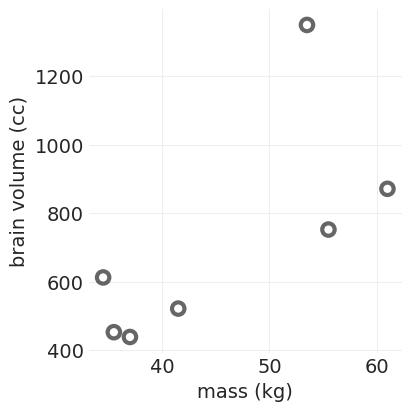

In [3]:
def plot_brain_mass_data(ax=None, data=BRAIN_MASS_TOY):
    if ax is not None:
        plt.sca(ax)
    utils.plot_scatter(data.mass, data.brain, color="k")
    plt.xlabel("mass (kg)")
    plt.ylabel("brain volume (cc)")


_, ax = plt.subplots(figsize=(4, 4))
plot_brain_mass_data(ax)

### Considerations
- what possible functions **describe** these points
  - **curve fitting & compression**
- what possible functions **explain** these points
  - this is the goal of **causal inference**
- what would happen if we changed one of the points mass?
  - **intervention**'
- given a new mass, what's the **expected value** of corresponding volume
  - **prediction**

## Leave-one-out Cross Validation (LOCCV)
Process for determining the ability for a model function to generalize -- i.e. accurately predicting **out-of-sample** data points.

1. Drop one data point
2. Fit the model function's parameters with the data point missing
3. Predict the value of the dropped point, record the error
4. Repeat 1-3 for all data points
5. The LOCCV score is the sum of errors on all the dropped points

In [4]:
def fit_polynomial_cross_validated(order, data):
    n_data_points = len(data)
    data_idx = np.arange(n_data_points)
    params = []
    for ii in range(n_data_points):
        shift = n_data_points - 1 - ii
        cross_val_idx = sorted(np.roll(data_idx, shift)[: n_data_points - 1])

        cross_val_x = data.mass[cross_val_idx]
        cross_val_y = data.brain[cross_val_idx]
        cross_val_params = np.polyfit(cross_val_x, cross_val_y, order)
        params.append(cross_val_params)
    return np.array(params)


def estimate_n_degree_model_crossvalidated(order, data, ylims=(300, 1400)):
    cross_val_params = fit_polynomial_cross_validated(order, data)
    insample_model = np.poly1d(np.polyfit(data.mass, data.brain, order))

    ca = plt.gca()
    plot_brain_mass_data(ax=ca, data=data)

    out_of_sample_error = 0
    insample_error = 0

    xs = np.linspace(data.mass.min(), data.mass.max(), 100)
    for holdout_idx, params in enumerate(cross_val_params):

        model = np.poly1d(params)
        ys = model(xs)
        utils.plot_line(xs, ys, color="gray", label=None, alpha=0.25)

        holdout_x = data.loc[holdout_idx, "mass"]
        holdout_y = data.loc[holdout_idx, "brain"]

        holdout_prediction = model(holdout_x)
        insample_prediction = insample_model(holdout_x)

        # Here we use absolute error
        holdout_error = np.abs(holdout_prediction - holdout_y)
        insample_error_ = np.abs(insample_prediction - holdout_y)

        out_of_sample_error += holdout_error
        insample_error += insample_error_

    ys = insample_model(xs)
    utils.plot_line(xs, ys, color="C1", linewidth=6, label="Average Model")
    plt.ylim(ylims)
    plt.title(
        f"Polynomial Terms: {order}\nIn-sample: {insample_error:1,.0f}\nOut-of-sample: {out_of_sample_error:1,.0f}"
    )

    return insample_error, out_of_sample_error

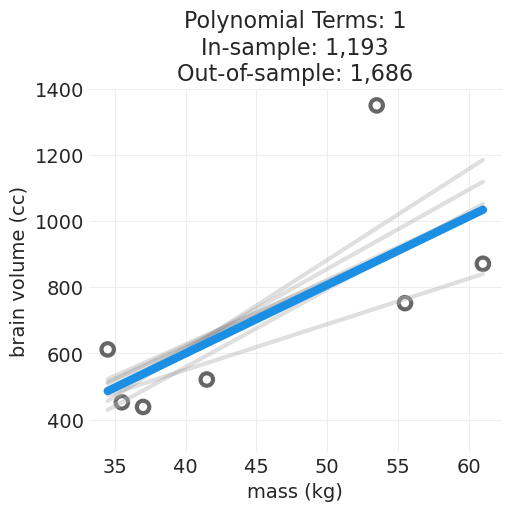

In [5]:
plt.subplots(figsize=(5, 5))
insample_error, outsample_error = estimate_n_degree_model_crossvalidated(1, data=BRAIN_MASS_TOY)

## Comparing Polynomial Models with LO0CV

In [6]:
def simulate_n_degree_polynomial_overfitting(data, ylims=(300, 1200)):

    fig, axs = plt.subplots(3, 2, figsize=(10, 12))
    insample_errors = []
    outsample_errors = []
    for ii in range(1, 6):
        row = (ii - 1) // 2
        col = (ii - 1) % 2
        plt.sca(axs[row, col])
        insample_error, outsample_error = estimate_n_degree_model_crossvalidated(
            ii, data=data, ylims=ylims
        )
        insample_errors.append(insample_error)
        outsample_errors.append(outsample_error)

    # rescale errors
    insample_errors = np.array(insample_errors)
    relative_insample_errors = insample_errors / insample_errors.sum()
    outsample_errors = np.array(outsample_errors)
    relative_outsample_errors = outsample_errors / outsample_errors.sum()

    plt.sca(axs[-1, -1])
    xs = np.arange(1, 6)

    utils.plot_line(xs, relative_insample_errors, color="C1", label="in-sample", alpha=1)
    utils.plot_scatter(
        xs, relative_insample_errors, color="C1", label=None, zorder=100, alpha=1, facecolors="w"
    )

    utils.plot_line(xs, relative_outsample_errors, color="C0", label="out-of-sample", alpha=1)
    utils.plot_scatter(
        xs, relative_outsample_errors, color="C0", label=None, zorder=100, alpha=1, facecolors="w"
    )
    plt.xlabel("polynomial terms")
    plt.ylabel("relative error")
    plt.legend()

    return outsample_errors, insample_errors

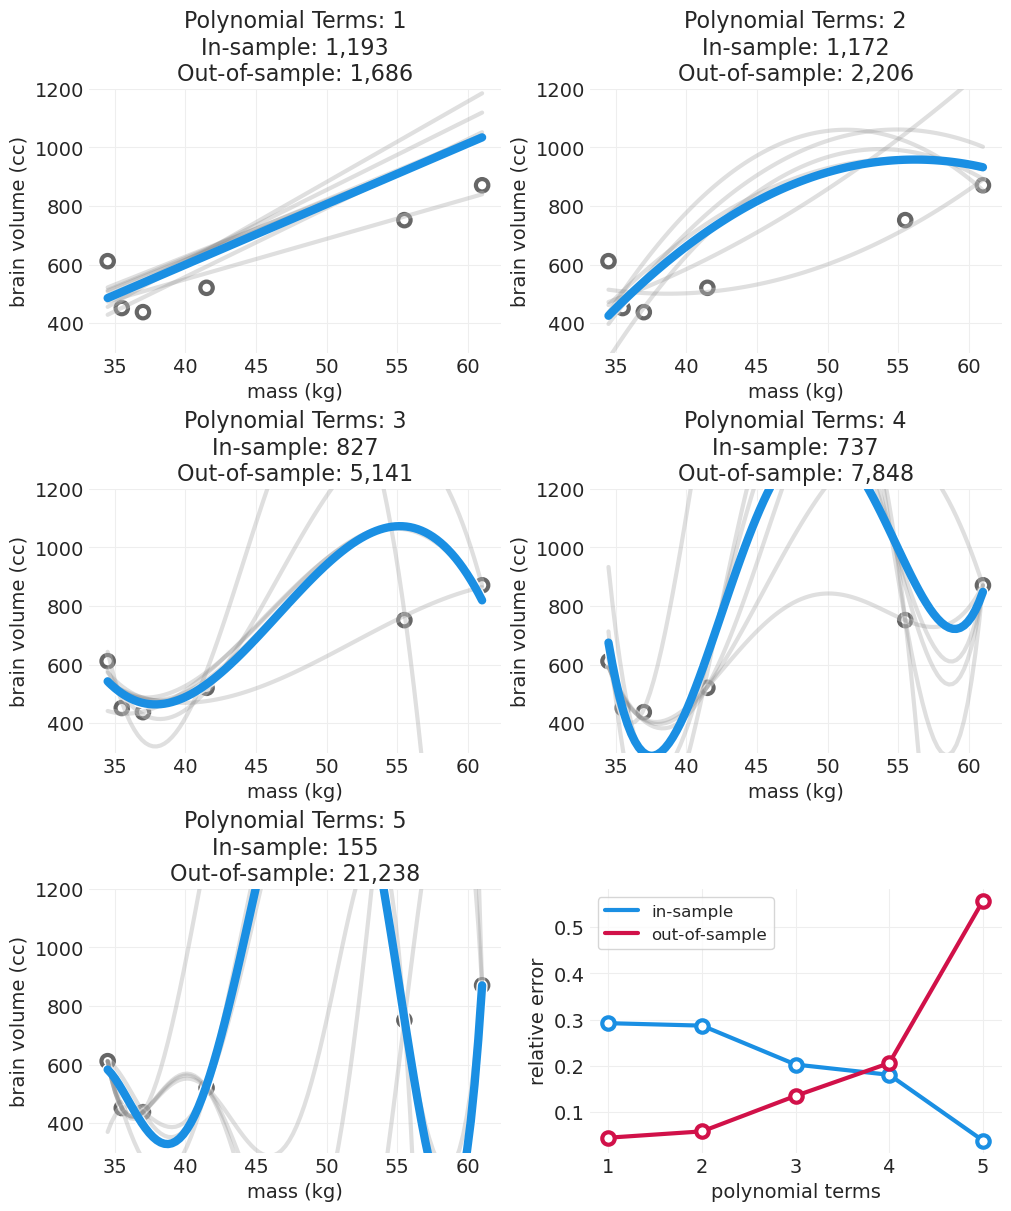

In [7]:
outsample_error, insample_error = simulate_n_degree_polynomial_overfitting(data=BRAIN_MASS_TOY);

As we increase the polynomial order
- The in-sample error reduces
- The out-of-sample error SKYROCKETS
- (at least for simple models) There's a tradeoff between model simplicity and complexity that is mirrored by the amount of in-sample and out-of-sample error
- There will be a "sweet spot" in model complexity that is just complex enough to fit the data, but not too complex to overfit to noise.
- This is known as the bias-variance tradeoff


**NOTE** this is all applicable to the goal of **prediction**, not causal inference.


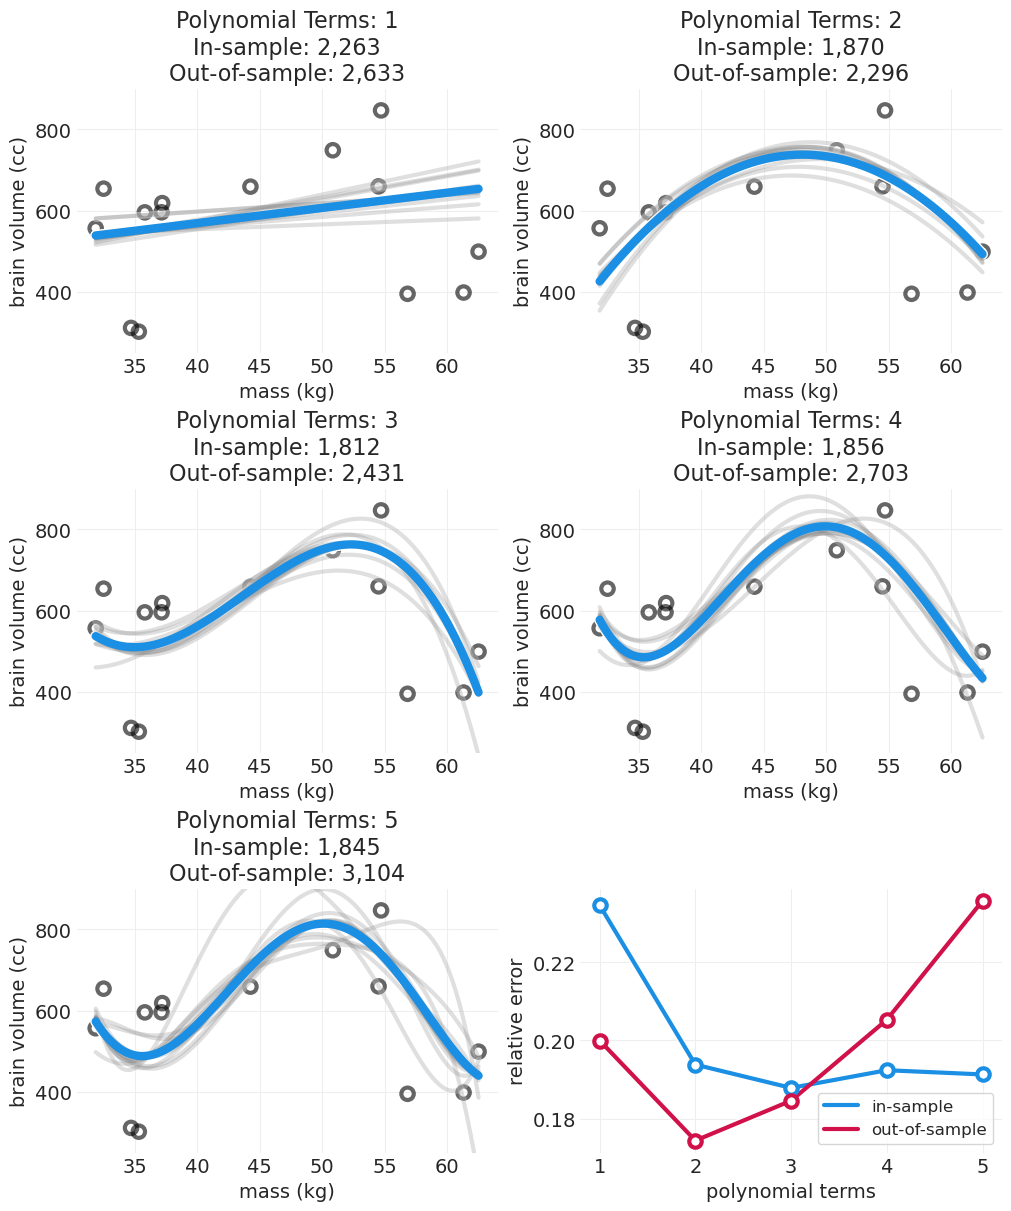

In [8]:
np.random.seed(1234)
n_samples = 15
# Run simulation with more data points
PRIMATE_DATA = utils.load_data("Primates301")[["brain", "body"]].dropna()

# preprocess the data a little
PRIMATE_DATA.loc[:, "brain"] = PRIMATE_DATA.brain * 10
PRIMATE_DATA.loc[:, "mass"] = PRIMATE_DATA.body / 100
PRIMATE_DATA = PRIMATE_DATA[PRIMATE_DATA.mass >= 30]
PRIMATE_DATA = PRIMATE_DATA[PRIMATE_DATA.mass <= 65]
PRIMATE_DATA = PRIMATE_DATA[PRIMATE_DATA.mass <= 900]

PRIMATE_DATA = PRIMATE_DATA.sample(n=n_samples).reset_index(drop=True)

np.random.seed(1234)
outsample_error, insample_error = simulate_n_degree_polynomial_overfitting(
    data=PRIMATE_DATA, ylims=(250, 900)
)

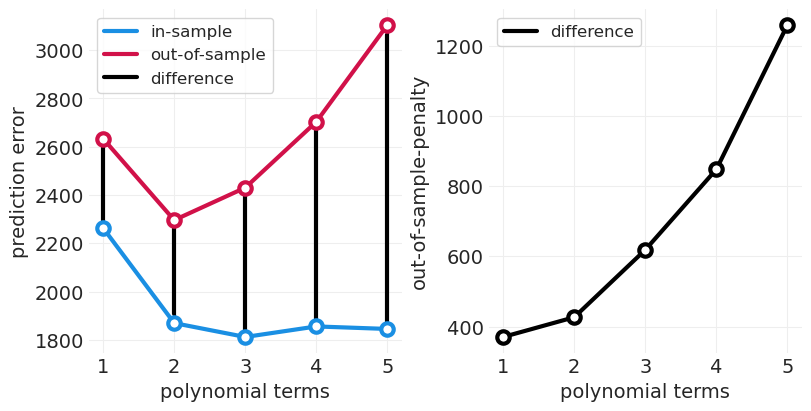

In [9]:
def plot_out_of_sample_penalty(outsample_error, insample_error):
    penalty = outsample_error - insample_error
    n_terms = len(penalty)
    xs = np.arange(1, n_terms + 1)

    _, axs = plt.subplots(1, 2, figsize=(8, 4))
    plt.sca(axs[0])
    utils.plot_scatter(
        xs, insample_error, color="C1", label=None, zorder=100, alpha=1, facecolors="w"
    )
    utils.plot_line(xs, insample_error, color="C1", label="in-sample", alpha=1)

    utils.plot_scatter(
        xs, outsample_error, color="C0", label=None, zorder=100, alpha=1, facecolors="w"
    )
    utils.plot_line(xs, outsample_error, color="C0", label="out-of-sample", alpha=1)

    for ii, (out, inn) in enumerate(zip(outsample_error, insample_error)):
        label = "difference" if not ii else None
        plt.plot((ii + 1, ii + 1), (out, inn), color="k", lw=3, label=label)

    plt.ylabel("prediction error")
    plt.xlabel("polynomial terms")
    plt.legend()

    plt.sca(axs[1])
    utils.plot_scatter(xs, penalty, color="black", label=None, zorder=100, alpha=1, facecolors="w")
    utils.plot_line(xs, penalty, color="black", label="difference", alpha=1)
    plt.xlabel("polynomial terms")
    plt.xticks(xs)
    plt.ylabel("out-of-sample-penalty")
    plt.legend()


plot_out_of_sample_penalty(outsample_error, insample_error)


## Regularization

- There will be a tradeoff between model flexibility and accuracy. Having a model that's too flexible can lead to overeighting the contribution of noise.
- Do no want your estimator to get too excited about rare outlier events. You want it to find **regular features**.
- Bayesian modeling uses tighter priors (in terms of variance) in order to be skeptical of unlikely events, tampering down the estimator's dendency to "get excited" about outlier events, thus reducing the model's flexibility to model those outliers.
  - Good priors are often tigher than one thinks
- The goal isn't signal compression (i.e. memorizing all features of the data), it is generalization in predictions.
 
> Cross validation is not regularization: CV can be used to compare models, but not to reduce flexibility (though we could average models)


### Regularizing Priors
- Use science: there's no replacement for domain knowledge
- Can tune priors with using CV
- Many tasks are a mix of inference and prediction, so weight the ability to predict and make actionable inferences

If we define the out-of-sample-penalty (OOSP) as the difference between the out-of-sample and in-sample error, we can see that as model complexity increases, so does the OOSP. We can use this metric for comparing models of different form and complexity by providing a signal for overfitting.

> McElreath goes on to show that Bayesian cross-validation metrics WAIC and PSIS closely track the OOSP returned by brute-force LOOCV (via the proxy lppd). It would be nice to replicate that chart in Python/PyMC, however, that's a lot of extra coding and model estimation for one plot, so I'm going to skip that one for now. That said, I'll show in the section on Robust Regression an example of using WAIC and PSIS returned from the PyMC.

## Penalty Prediction & Model (Mis-) Selection

For the simple example above, runing cross-validation to obtain in- and out-of-sample penality is no big deal. However, for more complex models that may take a long time to train, retraining multiple times can be prohibitive. Luckily there are some approximations to the CV procedure that allow us to obtain similar metrics directly from Bayesian models without having to explicitly run CV. These metrics include

- Pareto-smoothed Importance Sampling (PSIS)
- Waikake's Information Criterion (WAIC)

> When directly addressing causal inference problems, **do not use CV Penalties for selecting causal models**, this can result in selecting a confounded model. **Confounds often aid with prediction in the absence of intervention** by milking all association signals. However, there are many associations that we do not want to include when addressing causal problems.

### Example: Simulated Fungus Growth
The following is a translation of R code 6.13 from McElreath's v2 textbook that's used to simulate fungus growth on plants.

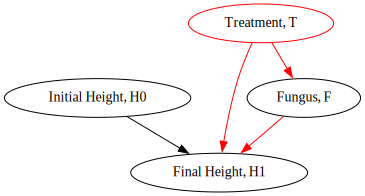

In [10]:
utils.draw_causal_graph(
    edge_list=[("H0", "H1"), ("T", "H1"), ("T", "F"), ("F", "H1")],
    node_props={
        "T": {"label": "Treatment, T", "color": "red"},
        "F": {"label": "Fungus, F"},
        "H0": {"label": "Initial Height, H0"},
        "H1": {"label": "Final Height, H1"},
    },
    edge_props={
        ("T", "F"): {"color": "red"},
        ("F", "H1"): {"color": "red"},
        ("T", "H1"): {"color": "red"},
    },
)

### Simulate the plant growth experiment

In [11]:
np.random.seed(12)

n_plants = 100

# Simulate initial heights
H0 = stats.norm.rvs(10, 2, size=n_plants)


# Treatment aids plant growth indirectly by reducing fungus,
# which has a negative effect on plant growth

# Simulate treatment
treatment = stats.bernoulli.rvs(p=0.5, size=n_plants)

# Simulate fungus growth conditioned on treatment
p_star = 0.5 - (treatment * 0.4)  # fungus is random when untreated, otherwise 10% chance
fungus = stats.bernoulli.rvs(p=p_star)

# Simulate final heights based on fungus
BETA_F = -3  # fungus hurts growth
ALPHA = 5
SIGMA = 1

mu = ALPHA + BETA_F * fungus
H1 = H0 + stats.norm.rvs(mu, SIGMA)

plants = pd.DataFrame(
    {"H0": H0, "treatment": treatment, "fungus": fungus, "H1": H1, "growth": H1 - H0}
)
plants.describe().T

,count,mean,std,min,25%,50%,75%,max
H0,100.0,9.711385,2.102440,3.705167,8.522114,9.779218,11.008820,15.743639
treatment,100.0,0.550000,0.500000,0.000000,0.000000,1.000000,1.000000,1.000000
fungus,100.0,0.250000,0.435194,0.000000,0.000000,0.000000,0.250000,1.000000
H1,100.0,14.040887,2.587388,8.749880,12.286543,13.830425,15.764303,20.348779
growth,100.0,4.329502,1.719949,-0.604996,3.259297,4.824692,5.532195,7.533324


If we are focusing on the total causal affect of Treatment, $T$ on final height $H1$

#### Incorrect adjustment set (stratifying by $F$)

$$
\begin{align*}
H_1 &\sim \mathcal{N}(\mu_i, \sigma) \\
\mu_i &= H_0 \times g_i \\
g_i &= \alpha + \beta_T T_i + \beta_F F_i
\end{align*}
$$

- incorporates treatment $T$ _and_ fungus, $F$, which is a post-treatment variable (bad for causal inference)
- $F$ would not have been found using backdoor criterion
- However, provides more accurate predictions than not incorporating $F$


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, alpha, beta_T, beta_F]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.


Output()

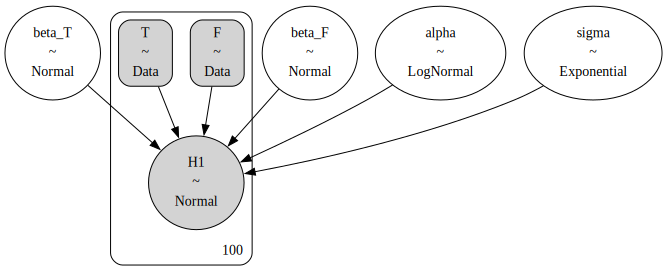

In [12]:
with pm.Model() as biased_model:
    # Priors
    sigma = pm.Exponential("sigma", 1)
    alpha = pm.LogNormal("alpha", 0.2)
    beta_T = pm.Normal("beta_T", 0, 0.5)
    beta_F = pm.Normal("beta_F", 0, 0.5)

    H0 = plants.H0.values
    H1 = plants.H1.values

    T = pm.Data("T", treatment.astype(float))
    F = pm.Data("F", fungus.astype(float))

    # proportional amount of growth
    g = alpha + beta_T * T + beta_F * F
    mu = g * H0

    # Likelihood
    pm.Normal("H1", mu, sigma, observed=H1)

    biased_inference = pm.sample(target_accept=0.95)
    pm.compute_log_likelihood(biased_inference)

pm.model_to_graphviz(biased_model)

#### Correct adjustment set (not stratifying by $F$)

$$
\begin{align*}
H_1 &\sim \mathcal{N}(\mu_i, \sigma) \\
\mu_i &= H_0 \times g_i \\
g_i &= \alpha + \beta_T T_i
\end{align*}
$$

- includes only treatment T
- less accurate predictions, despite being the correct causal model

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, alpha, beta_T]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.


Output()

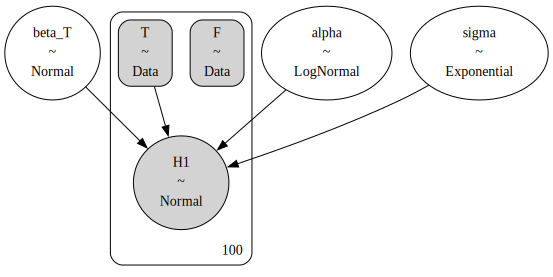

In [13]:
with pm.Model() as unbiased_model:
    # Priors
    sigma = pm.Exponential("sigma", 1.0)
    alpha = pm.LogNormal("alpha", 0.2)
    beta_T = pm.Normal("beta_T", 0, 0.5)

    H0 = plants.H0.values
    H1 = plants.H1.values

    T = pm.Data("T", treatment.astype(float))
    F = pm.Data("F", fungus.astype(float))

    # proportional amount of growth
    g = alpha + beta_T * T
    mu = g * H0

    # Likelihood
    pm.Normal("H1", mu, sigma, observed=H1)

    unbiased_inference = pm.sample(target_accept=0.95)
    pm.compute_log_likelihood(unbiased_inference)

pm.model_to_graphviz(unbiased_model)

#### Biased model provides better _predictions_ of the data
We can see that by comparing LOO Cross validation scores, the biased model is ranked higher:
- biased model weight = 1
- ELPD (deviance) is lower (indicating better predictions out of sample)

In [14]:
comparison = az.compare(
    {"H1 ~ H0 + T + F": biased_inference, "H1 ~ H0 + T": unbiased_inference}, scale="deviance"
)
comparison

,rank,elpd_loo,p_loo,elpd_diff,weight,se,dse,warning,scale
H1 ~ H0 + T + F,0,343.573135,4.186477,0.000000,1.000000e+00,15.426043,0.0000,False,deviance
H1 ~ H0 + T,1,425.412309,3.566714,81.839174,1.335820e-12,17.616036,16.9891,False,deviance


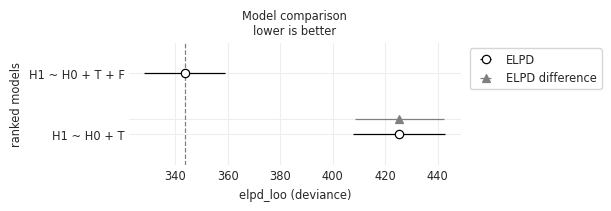

In [15]:
az.plot_compare(comparison, insample_dev=False);

#### However, the unbiased model recovers the correct causal effect

In [16]:
az.summary(biased_inference)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha,1.539,0.026,1.490,1.589,0.001,0.000,1833.0,2070.0,1.0
beta_F,-0.362,0.033,-0.421,-0.299,0.001,0.001,2089.0,2454.0,1.0
beta_T,-0.034,0.030,-0.086,0.022,0.001,0.000,1895.0,2390.0,1.0
sigma,1.319,0.095,1.140,1.489,0.002,0.001,2539.0,2584.0,1.0


In [17]:
az.summary(unbiased_inference)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha,1.369,0.032,1.308,1.426,0.001,0.001,1776.0,1806.0,1.0
beta_T,0.091,0.041,0.015,0.171,0.001,0.001,1824.0,2052.0,1.0
sigma,1.985,0.140,1.721,2.234,0.003,0.002,2366.0,2417.0,1.0


Plotting the posteriors of each model provide different results. The biased model suggests that there is no, or even negative effect of the treatment on plant growth. We know this is not true because the simulation either has 0 effect for the untreated, or a positive effect (indirectly by reducting fungus) on plant growth.

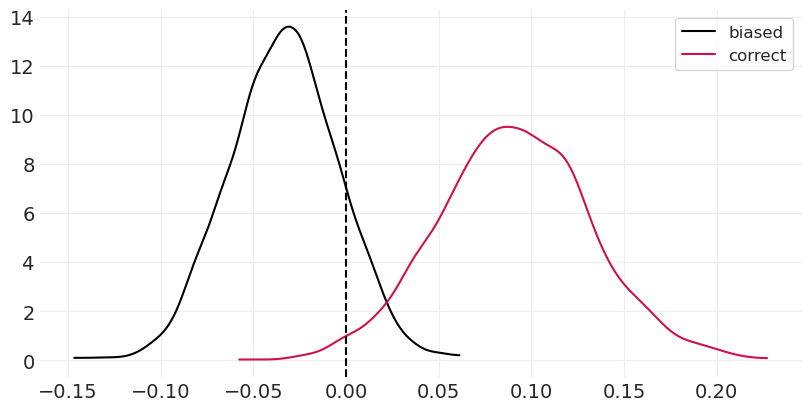

In [18]:
_, ax = plt.subplots(figsize=(8, 4))
az.plot_dist(biased_inference.posterior["beta_T"], ax=ax, color="black", label="biased")
az.plot_dist(unbiased_inference.posterior["beta_T"], ax=ax, color="C0", label="correct")
plt.axvline(0, linestyle="dashed", color="k");

### Why does the wrong model win at prediction?
- Fungus is a better _predictor_ of growth than treatment.
  - there is a clear (negative) linear relationship between fungus and growth (left plot below)
    - i.e. the marginals are better separated when separating by fungus
  - control / treatment provides a much less 
    - i.e. the marginals are highly overalping when splitting by treatment
  - there are fewer fungus points in the treatment group (see right plot below). This provides less predictive signal in the training set for assessing the predictive association between treatment and growth.

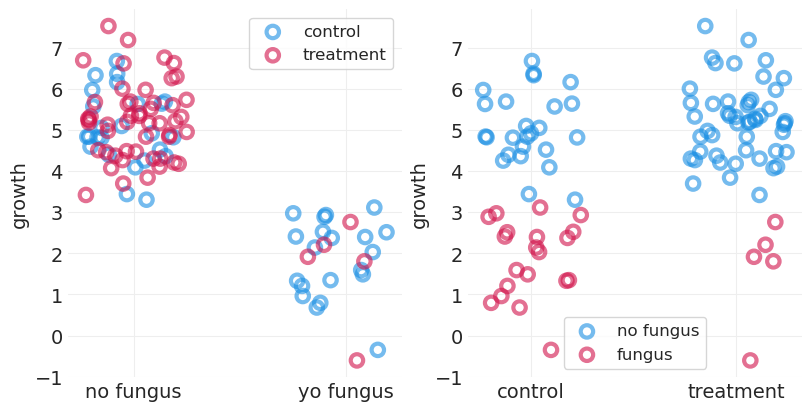

In [19]:
_, axs = plt.subplots(1, 2, figsize=(8, 4))

plt.sca(axs[0])
for treat, label in enumerate(["control", "treatment"]):
    plot_data = plants[plants.treatment == treat]
    jitter = 0.5 * (np.random.rand(len(plot_data)) - 0.5)
    color = f"C{np.abs(treat - 1)}"
    utils.plot_scatter(plot_data.fungus + jitter, plot_data.growth, color=color, label=label)

plt.xticks([0, 1], labels=["no fungus", "yo fungus"])
plt.legend()
plt.ylabel("growth")

plt.sca(axs[1])
for fungus, label in enumerate(["no fungus", "fungus"]):
    plot_data = plants[plants.fungus == fungus]
    jitter = 0.5 * (np.random.rand(len(plot_data)) - 0.5)
    color = f"C{np.abs(fungus - 1)}"
    utils.plot_scatter(plot_data.treatment + jitter, plot_data.growth, color=color, label=label)

plt.xticks([0, 1], labels=["control", "treatment"])
plt.ylabel("growth")

plt.legend();

### Model Mis-selection
- **NEVER use predictive tools (WAIC, PSIS, CV / OOSPS) to choose a causal estimate**
- Most analyses are a mix of prediction and inference.
- Accurate functional descriptions create simpler, more parsimonious models that are less prone to overfitting, so **use science where possible**

## Outliers and Robust Regression
- Outliers are more influential on the posterior than "normal" points
  - You can quantify this using CV -- this is related to Importance Sampling
- Do not drop outliers, they are still signal
  - The model is wrong, not the data
  - e.g. Mixture models & robust regression


### Example: Divorce Rate
- Maine & Idaho both unusual
- Maine: High divorce rate for average marriage age
- Idaho: Low divorce rate and less-than-average marriage age

What is the influence of outlier points like Idaho and Maine?

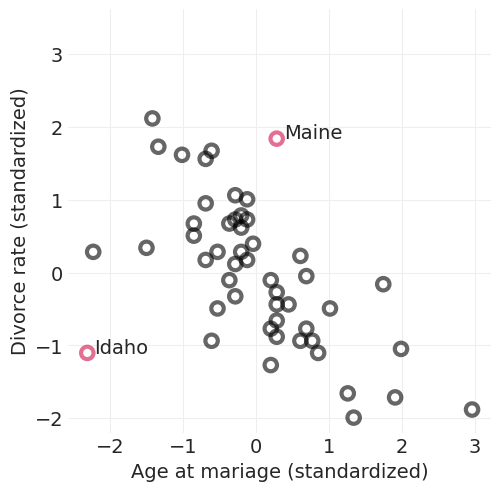

In [20]:
divorce = utils.load_data("WaffleDivorce")[["Location", "Divorce", "MedianAgeMarriage"]]

inliers_idx = divorce.query("Location not in ('Idaho', 'Maine')").index.tolist()
outliers_idx = divorce.query("Location in ('Idaho', 'Maine')").index.tolist()


std_age = utils.standardize(divorce.MedianAgeMarriage)
std_divorce = utils.standardize(divorce.Divorce)

utils.plot_scatter(std_age[inliers_idx], std_divorce[inliers_idx], color="k", label=None)
utils.plot_scatter(std_age[outliers_idx], std_divorce[outliers_idx], color="C0", label=None)

for oi in outliers_idx:
    plt.annotate(divorce.loc[oi, "Location"], (std_age[oi] + 0.1, std_divorce[oi]), fontsize=14)

plt.xlabel("Age at mariage (standardized)")
plt.ylabel("Divorce rate (standardized)")
plt.axis("square");

### Fit Least Square Model

In [21]:
with pm.Model() as lstsq_model:
    # Priors
    sigma = pm.Exponential("sigma", 1)
    alpha = pm.Normal("alpha", 0, 0.5)
    beta_A = pm.Normal("beta_A", 0, 0.5)

    # Likelihood
    mu = alpha + beta_A * std_age.values
    pm.Normal("divorce", mu, sigma, observed=std_divorce.values)
    lstsq_inference = pm.sample()

    # required for LOOCV score
    pm.compute_log_likelihood(lstsq_inference)

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, alpha, beta_A]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.


Output()

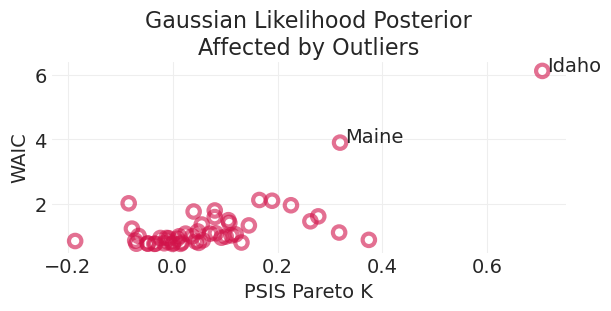

In [22]:
# Calculate Pointwise LOOCV scores
def plot_loocv(inference, title=None):
    plt.subplots(figsize=(6, 3))
    pareto_k = az.loo(inference, pointwise=True).pareto_k
    waic = -az.waic(inference, pointwise=True).waic_i

    utils.plot_scatter(pareto_k, waic, color="C0", label=None)
    for oi in outliers_idx:
        plt.annotate(divorce.loc[oi, "Location"], (pareto_k[oi] + 0.01, waic[oi]), fontsize=14)
    plt.xlabel("PSIS Pareto K")
    plt.ylabel("WAIC")
    plt.title(title)


plot_loocv(lstsq_inference, title="Gaussian Likelihood Posterior\nAffected by Outliers")

Here we can see that the two outliers have large effect on the the Normal Likelihood model posterior. This is because the outliers have very low probability under the Normal distribution, and thus are very "surprising" or "salient".

## Mixing Gaussians -- the Student-T
- Adding Gaussians of differing variances results in a distribution with fatter tails
- Implicilty captures unobserved heterogeneity in the population
  - Multiple overlapping processes could have different variances.

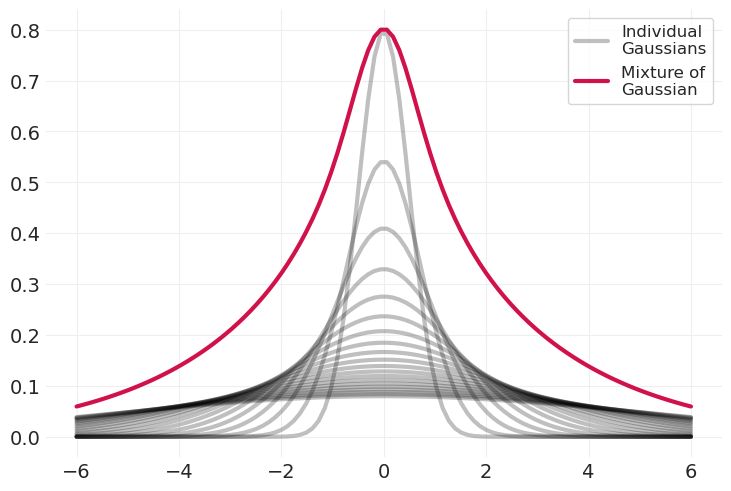

In [23]:
xs = np.linspace(-6, 6, 100)
pdfs = []
n_gaussians = 20
for variance in np.linspace(0.5, 5, n_gaussians):
    label = "Individual\nGaussians" if variance == 0.5 else None
    pdf = stats.norm(0, variance).pdf(xs)
    pdfs.append(pdf)
    utils.plot_line(xs, pdf, color="k", label=label, alpha=0.25)

sum_of_pdfs = np.array(pdfs).sum(axis=0)
sum_of_pdfs /= sum_of_pdfs.max()
sum_of_pdfs *= 1 - n_gaussians / 100

utils.plot_line(xs, sum_of_pdfs, color="C0", label="Mixture of\nGaussian")
plt.legend();

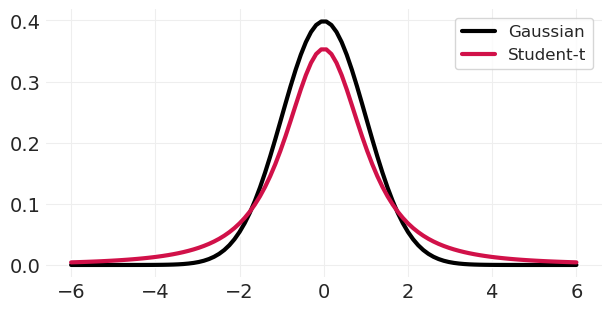

In [24]:
plt.subplots(figsize=(6, 3))

utils.plot_line(xs, stats.norm.pdf(xs), color="k", label="Gaussian")
utils.plot_line(xs, stats.t(2).pdf(xs), color="C0", label="Student-t")
plt.legend();

## Robust Linear Regression Using the Student-t Likelihood

In [25]:
with pm.Model() as studentt_model:
    # Priors
    sigma = pm.Exponential("sigma", 1)
    alpha = pm.Normal("alpha", 0, 0.5)
    beta_A = pm.Normal("beta_A", 0, 0.5)

    # Likelihood
    mu = alpha + beta_A * std_age.values
    # Replacing Gaussian with Student T -- note, we just "choose" 2 as our degrees of freedom
    pm.StudentT("divorce", nu=2, mu=mu, sigma=sigma, observed=std_divorce.values)
    studentt_inference = pm.sample()
    pm.compute_log_likelihood(studentt_inference)

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, alpha, beta_A]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.


Output()

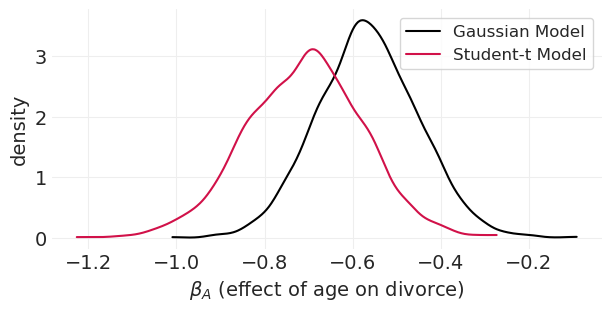

In [26]:
plt.subplots(figsize=(6, 3))
az.plot_dist(lstsq_inference.posterior["beta_A"], color="k", label="Gaussian Model")
az.plot_dist(studentt_inference.posterior["beta_A"], color="C0", label="Student-t Model")
plt.xlabel("$\\beta_A$ (effect of age on divorce)")
plt.ylabel("density");

Here we can see how the outliers pull the posterior closer to zero in the vanilla Gaussian linear regression. The more robust student-t model is less affected by those outliers.

#### Outliers have less effect on Student-t posterior
We can see that using a likelihood more robust to outliers weighs those outliers less, as indicated by Maine and Idaho given less extreme posteior importance weights, particularly for PSIS.

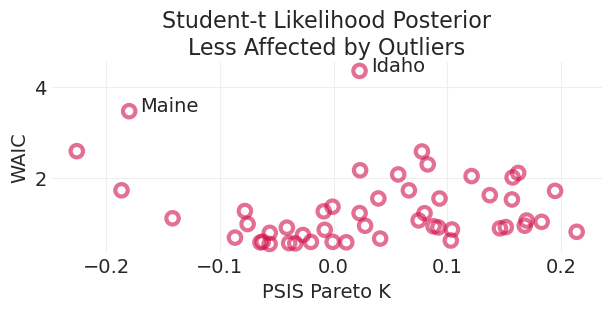

In [27]:
plot_loocv(studentt_inference, title="Student-t Likelihood Posterior\nLess Affected by Outliers")

## Review: Robust Regression
- Mixture of Gaussians / Student-t implicilty captures unobserved heterogeneity in the population
- This results in "thick tailed" distributions that are "less surprised" by outliers
- We "just set" the degrees of freedom parameters in the Student-t. It turns out it is hard to accurately estimate degrees of freedom from the data because outlier values are rare.
- Should we just use Robust Regression by default for under-theorized domains?
  - Probably a good idea
  - Example: The world is becoming more peacful since early 1900s.
    - Thick tailed-distributions would suggest that large-scale conflicts like those in early 1900s are not surprising, but are to be expected from processes like societal conflicts that can compound and "run-away" (which tend to be long-tailed).

## Authors
* Ported to PyMC by Dustin Stansbury (2024)
* Based on Statistical Rethinking (2023) lectures by Richard McElreath

In [28]:
%load_ext watermark
%watermark -n -u -v -iv -w -p pytensor,aeppl,xarray

Last updated: Tue Dec 17 2024

Python implementation: CPython
Python version       : 3.12.5
IPython version      : 8.27.0

pytensor: 2.26.4
aeppl   : not installed
xarray  : 2024.7.0

statsmodels: 0.14.2
scipy      : 1.14.1
xarray     : 2024.7.0
matplotlib : 3.9.2
numpy      : 1.26.4
pandas     : 2.2.2
pymc       : 5.19.1
arviz      : 0.19.0

Watermark: 2.5.0



:::{include} ../page_footer.md
:::